## TUIA 4° cuatrimestre

# Minería de Datos

## Trabajo Práctico N°2

## Integrantes: Menescaldi Brisa, Vercesi Patricio

### Importaciones

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import Source
!pip install mplcursors -q
import mplcursors

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
files.upload();

Saving 1000_Companies.csv to 1000_Companies (6).csv
Saving PokemonDB.csv to PokemonDB (6).csv


## Modelos de Regresión sobre dataset de Compañías

### 1) Preprocesamiento de datos

#### Exploración de datos

In [ ]:
df = pd.read_csv('1000_Companies.csv')

Saving 1000_Companies.csv to 1000_Companies (4).csv
Saving PokemonDB.csv to PokemonDB (4).csv


In [ ]:
df

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.800,471784.1000,New York,192261.83000
1,162597.70,151377.590,443898.5300,California,191792.06000
2,153441.51,101145.550,407934.5400,Florida,191050.39000
3,144372.41,118671.850,383199.6200,New York,182901.99000
4,142107.34,91391.770,366168.4200,Florida,166187.94000
...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,California,95279.96251
996,134970.00,130390.080,329204.0228,California,164336.60550
997,100275.47,241926.310,227142.8200,California,413956.48000
998,128456.23,321652.140,281692.3200,California,333962.19000


In [ ]:
df.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [ ]:
estado= df['State'].value_counts()
print(estado)

California    344
New York      334
Florida       322
Name: State, dtype: int64


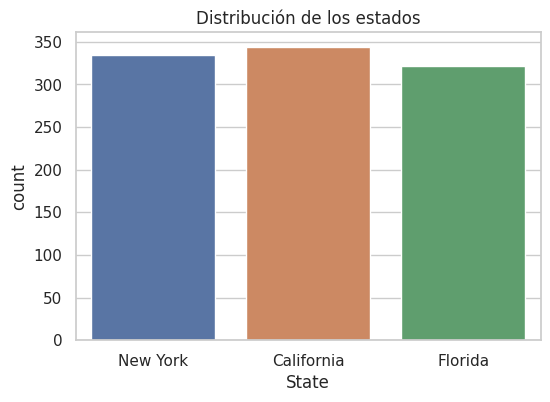

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x='State', data=df)
plt.title('Distribución de los estados')
plt.show()

No hay valores faltantes ni nulos y hay una buena distribución en los valores de la columna 'State'

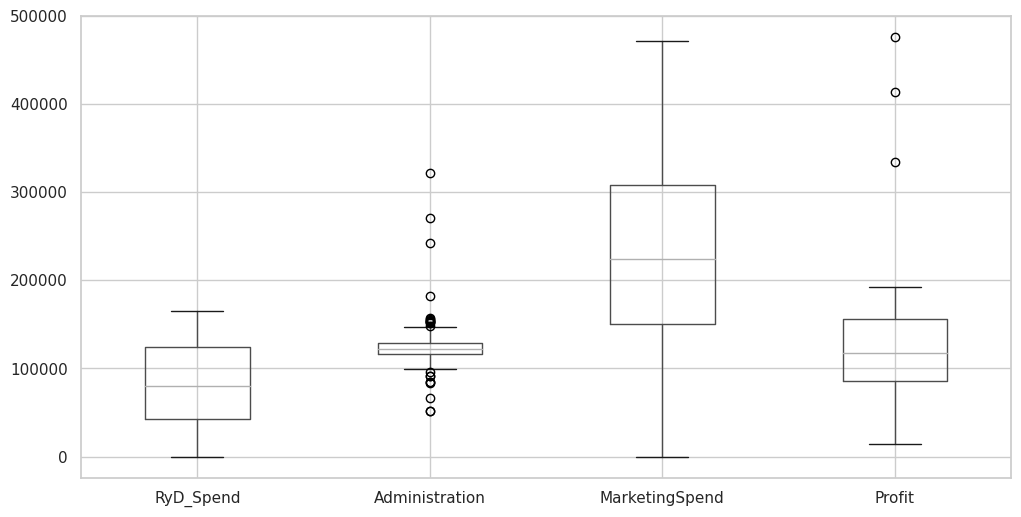

In [ ]:
plt.figure(figsize=(12, 6))
df.boxplot()
plt.show()

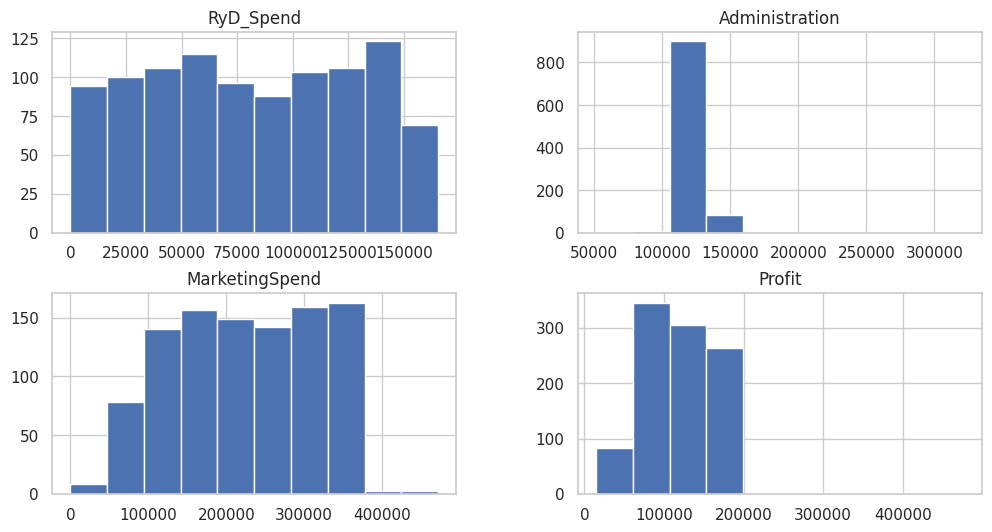

In [ ]:
df.hist(figsize=(12, 6))
plt.show()

Se encuentran outliers en las columnas 'Administration' y 'Profit' pero en los histogramas no se ven como valores atípicos.
A su vez destacamos que para la columna 'Administration' la gran cantidad de datos se encuentran centrados y los restantes se ven de forma simétrica distribuidos del centro.

#### Estandarización

In [ ]:
col = df[['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit']]
col_std = StandardScaler().fit_transform(col);

In [ ]:
df_std = pd.DataFrame(col_std, columns=['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit'])
df_std

,RyD_Spend,Administration,MarketingSpend,Profit
0,1.799023,1.105197,2.682968,1.696301
1,1.739869,2.253692,2.378316,1.685343
2,1.543022,-1.730568,1.985407,1.668041
3,1.348048,-0.340433,1.715177,1.477956
4,1.299351,-2.504210,1.529110,1.088053
...,...,...,...,...
995,-0.591946,-0.357871,-0.578727,-0.566079
996,1.145907,0.589023,1.125271,1.044865
997,0.400018,9.435756,0.010245,6.867965
998,1.005869,15.759379,0.606202,5.001869


### 2) Árboles de Decisión de regresión

In [ ]:
x = df_std.drop('Profit', axis=1)
y = df_std['Profit']

#### Optimización de hiperparámetros

Obtenemos los mejores parámetros para el máximo profundidad, número mínimo de observaciones, número mínimo de observaciones por separación y criterio de separación.

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [None, 5, 8, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4, 6],
    'min_samples_split': [2, 3, 4, 5],
    'criterion': ["squared_error", "absolute_error", "friedman_mse"]
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(xTrain, yTrain)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

best_model = grid_search.best_estimator_

Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Gráfico del árbol obtenido

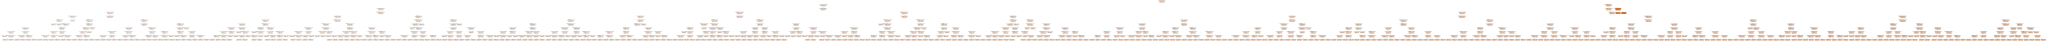

In [ ]:
export_graphviz(best_model, out_file="Profit.dot", feature_names=x.columns, class_names=y, rounded=True, filled=True)
Source.from_file("Profit.dot")

#### Evaluaciones

Primera división

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=0) # División definida por random_state = 0

yPred = best_model.predict(xTest)
print('RMSE sobre los datos de test:', np.sqrt(metrics.mean_squared_error(yTest, yPred)))

RMSE sobre los datos de test: 0.003442712068746758


Segunda división

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=12345) # División definida por random_state = 12345

yPred = best_model.predict(xTest)
print('RMSE sobre los datos de test:', np.sqrt(metrics.mean_squared_error(yTest, yPred)))

RMSE sobre los datos de test: 0.017337630193550002


## Modelos de Clasificación sobre dataset de Pokémon

### 3) Preprocesamiento de datos

#### Exploración de datos

In [ ]:
dataframe = pd.read_csv('PokemonDB.csv')

In [ ]:
dataframe

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65
...,...,...,...,...,...,...,...,...
1185,Chi-Yu,Dark,55,80,80,135,120,100
1186,Roaring Moon,Dragon,105,139,71,55,101,119
1187,Iron Valiant,Fairy,74,130,90,120,60,116
1188,Koraidon,Fighting,100,135,115,85,100,135


In [ ]:
nombres= dataframe['Name'].value_counts()
print(nombres)

Rotom           6
Squawkabilly    4
Oricorio        4
Necrozma        4
Gourgeist       4
               ..
Infernape       1
Piplup          1
Prinplup        1
Empoleon        1
Miraidon        1
Name: Name, Length: 1008, dtype: int64


Encontramos nombres repetidos

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


No hay valores faltantes ni nulos

In [ ]:
dataframe.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,70.852941,80.957983,74.586555,72.756303,72.050420,69.695798
std,26.886443,32.119650,30.718212,32.658636,27.637522,30.204376
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,51.250000,56.000000,51.000000,50.000000,50.000000,45.000000
50%,70.000000,80.000000,70.000000,65.000000,70.000000,67.000000
75%,85.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000


In [ ]:
tipo= dataframe['Type'].value_counts()
print(tipo)

Water       149
Normal      131
Grass       104
Bug          91
Psychic      82
Fire         75
Electric     73
Rock         67
Dark         56
Fighting     49
Dragon       47
Ghost        47
Poison       46
Ground       46
Ice          43
Steel        43
Fairy        31
Flying       10
Name: Type, dtype: int64


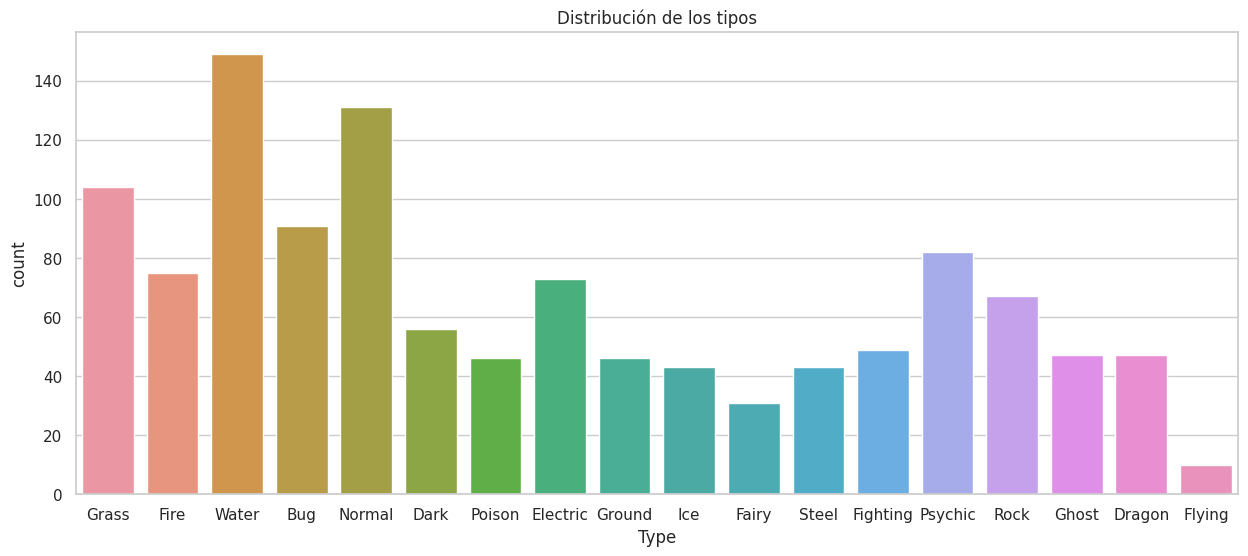

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,6))
sns.countplot(x='Type', data=dataframe)
plt.title('Distribución de los tipos')
plt.show()

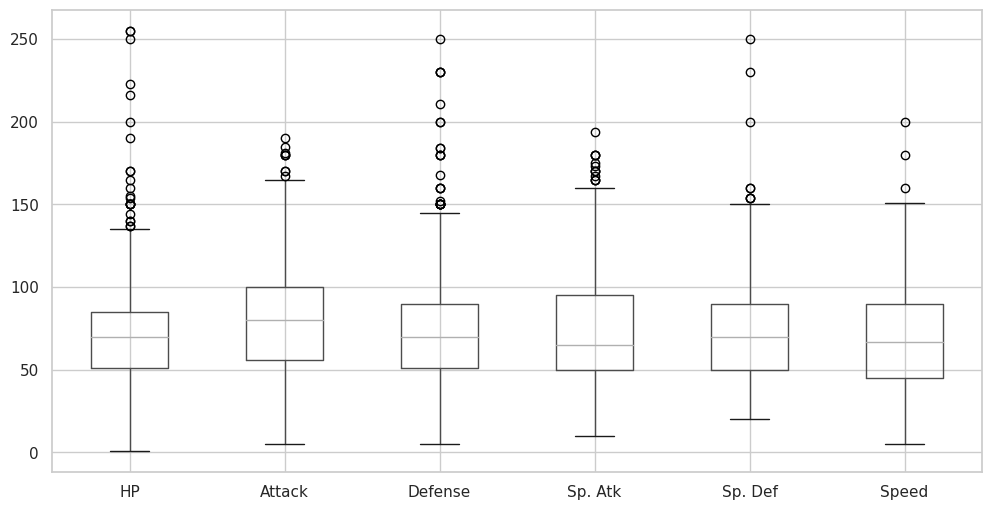

In [ ]:
plt.figure(figsize=(12, 6))
dataframe.boxplot()
plt.show()

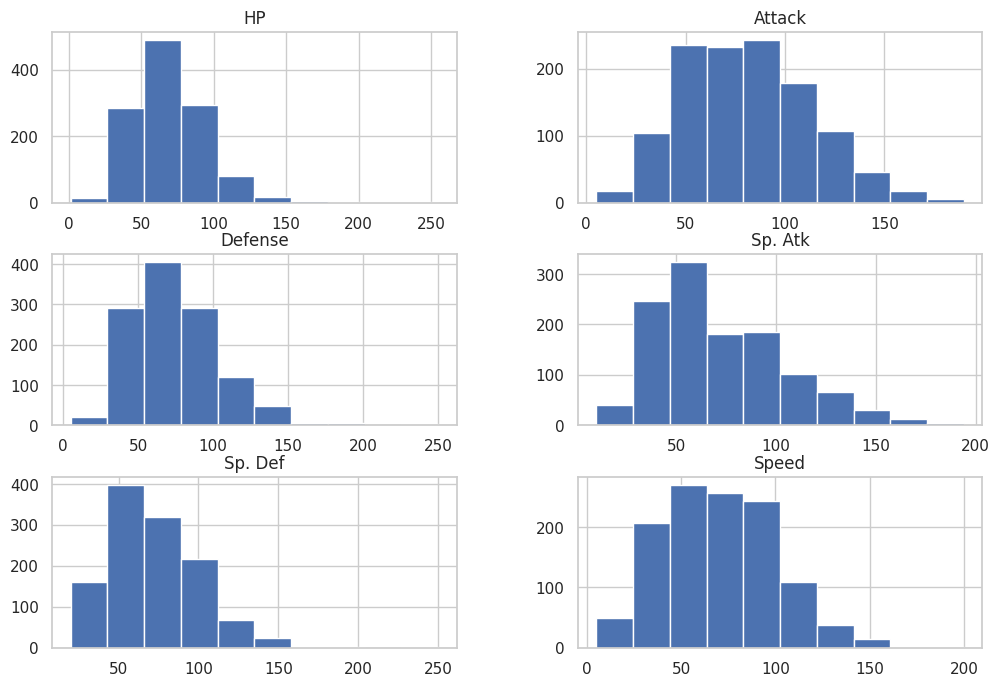

In [ ]:
dataframe.hist(figsize=(12, 8))
plt.show()

#### Estandarización

In [ ]:
columnas = dataframe[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
columna_std = StandardScaler().fit_transform(columnas)

dataframe_std = pd.DataFrame(columna_std, columns=['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed'])
dataframe_std['Name'] = dataframe['Name']
dataframe_std['Type'] = dataframe['Type']

In [ ]:
dataframe_std

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type
0,-0.961965,-0.995385,-0.833294,-0.237596,-0.255210,-0.817967,Bulbasaur,Grass
1,-0.403828,-0.590478,-0.377347,0.221894,0.287758,-0.321141,Ivysaur,Grass
2,0.340354,0.032455,0.274006,0.834547,1.011716,0.341293,Venusaur,Grass
3,0.340354,0.593096,1.576713,1.508465,1.735674,0.341293,Venusaur,Grass
4,-1.185219,-0.901945,-1.028700,-0.390759,-0.798179,-0.155533,Charmander,Fire
...,...,...,...,...,...,...,...,...
1185,-0.589874,-0.029838,0.176303,1.906689,1.735674,1.003727,Chi-Yu,Dark
1186,1.270581,1.807816,-0.116806,-0.543923,1.047914,1.633039,Roaring Moon,Dragon
1187,0.117099,1.527496,0.501980,1.447199,-0.436200,1.533674,Iron Valiant,Fairy
1188,1.084536,1.683229,1.316172,0.375057,1.011716,2.162986,Koraidon,Fighting


### 4) Árboles de Decisión de clasificación

In [ ]:
dataframe_std['Type'] = dataframe_std['Type'].astype('category')
dataframe_std['Name'] = dataframe_std['Name'].astype('category')

In [ ]:
# Aplicar label encoding, que le asigna un número entero a las variables categoricas
label_encoder = LabelEncoder()
dataframe_std['Tipo'] = label_encoder.fit_transform(dataframe_std['Type'])
dataframe_std['Nombre'] = label_encoder.fit_transform(dataframe_std['Name'])

In [ ]:
dataframe_std

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Name,Type,Tipo,Nombre
0,-0.961965,-0.995385,-0.833294,-0.237596,-0.255210,-0.817967,Bulbasaur,Grass,9,93
1,-0.403828,-0.590478,-0.377347,0.221894,0.287758,-0.321141,Ivysaur,Grass,9,423
2,0.340354,0.032455,0.274006,0.834547,1.011716,0.341293,Venusaur,Grass,9,940
3,0.340354,0.593096,1.576713,1.508465,1.735674,0.341293,Venusaur,Grass,9,940
4,-1.185219,-0.901945,-1.028700,-0.390759,-0.798179,-0.155533,Charmander,Fire,6,123
...,...,...,...,...,...,...,...,...,...,...
1185,-0.589874,-0.029838,0.176303,1.906689,1.735674,1.003727,Chi-Yu,Dark,1,131
1186,1.270581,1.807816,-0.116806,-0.543923,1.047914,1.633039,Roaring Moon,Dragon,2,716
1187,0.117099,1.527496,0.501980,1.447199,-0.436200,1.533674,Iron Valiant,Fairy,4,422
1188,1.084536,1.683229,1.316172,0.375057,1.011716,2.162986,Koraidon,Fighting,5,455


In [ ]:
X = dataframe_std.drop(['Tipo','Type','Name', 'Nombre'], axis=1)
Y = dataframe_std['Tipo']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Optimización de hiperparámetros

In [ ]:
param_space = {
    'max_depth': [3, 5, 7, 9, 11],
    'max_features': [3, 5, 6, 7, 9],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'criterion': ['gini', 'entropy']
}

# Encontrado de parámetros
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_space, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Entrenamos un modelo con los mejores hiperparámetros
best_tree = DecisionTreeClassifier(**best_params)
best_tree.fit(X_train, Y_train);

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 6, 'min_samples_split': 5}


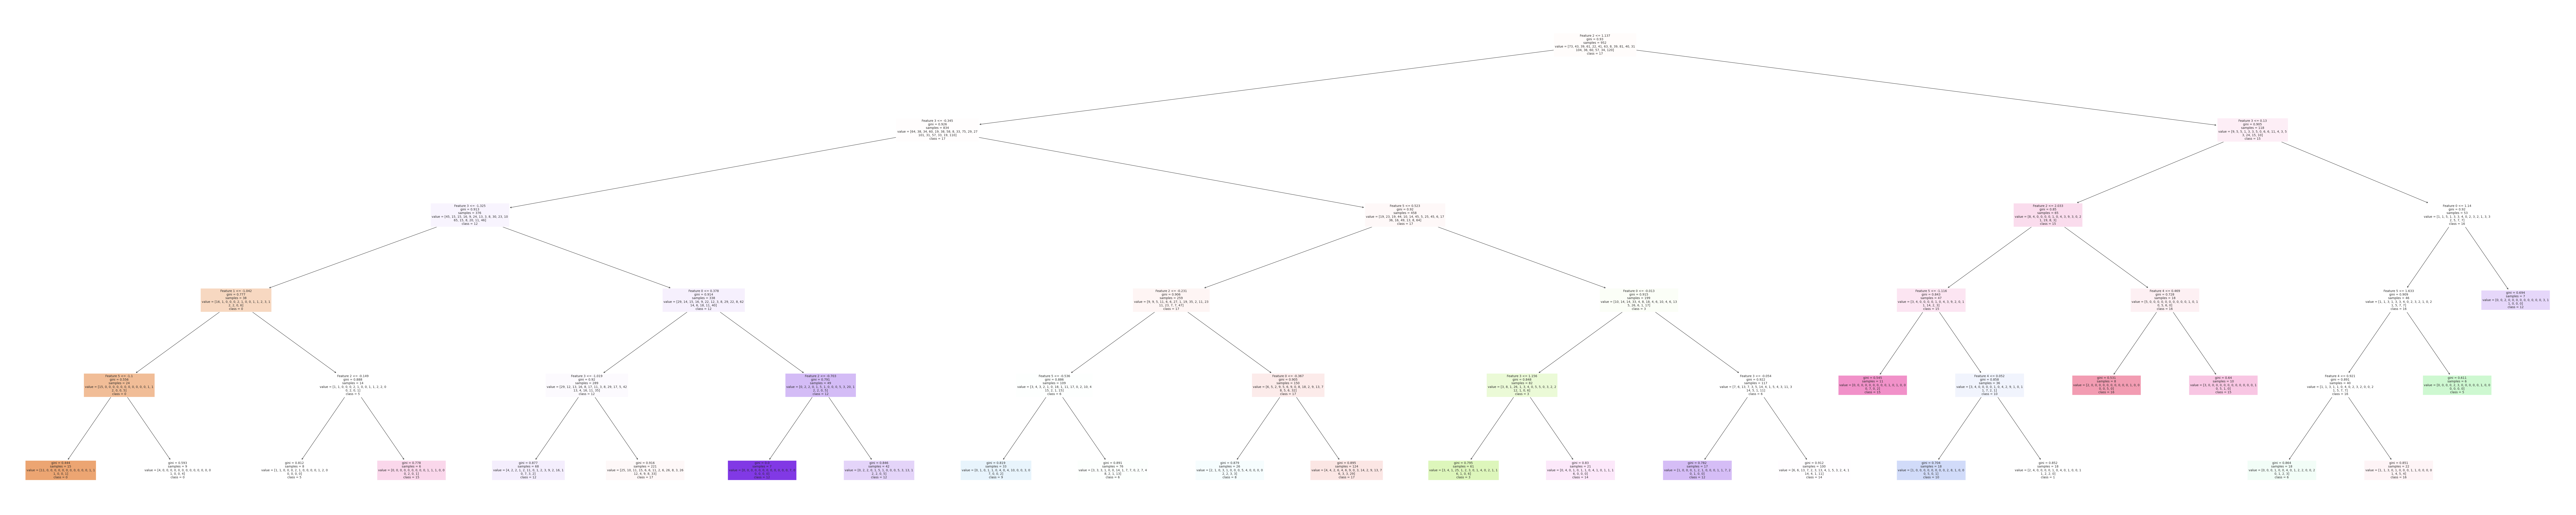

In [ ]:
plt.figure(figsize=(150, 30))
plot_tree(best_tree, feature_names=[f'Feature {i}' for i in range(X.shape[1])], class_names=[str(cls) for cls in best_tree.classes_], filled=True, fontsize=10)
mplcursors.cursor(hover=True)
plt.show()

Cliqueando en el gráfico se puede examinar más de cerca todos los nodos

#### Evaluaciones

Primera evaluación

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

y_pred = best_tree.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro', zero_division=0.0)
recall = recall_score(Y_test, y_pred, average='macro', zero_division=0.0)

print("Resultados en el conjunto de prueba 1:")
print(f"Precisión promedio: {precision}")
print(f"Exhaustividad promedia: {recall}")
print(f"Exactitud: {accuracy}")

Resultados en el conjunto de prueba 1:
Exactitud: 0.12605042016806722
Precisión promedio: 0.0889565034726325
Exhaustividad promedia: 0.08436508457331379


Segunda evaluación

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

y_pred = best_tree.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro', zero_division=0.0)
recall = recall_score(Y_test, y_pred, average='macro', zero_division=0.0)

print("Resultados en el conjunto de prueba 2:")
print(f"Precisión: {precision}")
print(f"Exhaustividad: {recall}")
print(f"Exactitud: {accuracy}")

Resultados en el conjunto de prueba 2:
Exactitud: 0.2184873949579832
Precisión: 0.1570500404281766
Exhaustividad: 0.13522274156332126


### 5) Bayes Ingenuo

In [ ]:
X = dataframe_std.drop(['Tipo','Type','Name', 'Nombre'], axis=1)
Y = dataframe_std['Type']

#### Recategorización

In [ ]:
def float_range(start, end, num_parts):
    step = (end-start)/num_parts
    current = start
    yield current
    for i in range(num_parts-1):
        current += step
        current = round(current, 9)
        yield current

In [ ]:
num_categories = 8

labels = list(range(1, num_categories+1))
q = [x for x in float_range(0.0, 1.0, num_categories)]+[1.0]

Xc = X.copy()
for col in Xc:
    Xc[col] = pd.qcut(Xc[col], q=q, labels=labels)

Xc = Xc.astype(float)
Xc

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,2.0,2.0,2.0,4.0,4.0,2.0
1,3.0,3.0,4.0,5.0,5.0,4.0
2,6.0,5.0,6.0,7.0,7.0,5.0
3,6.0,6.0,8.0,8.0,8.0,5.0
4,1.0,2.0,2.0,4.0,2.0,4.0
...,...,...,...,...,...,...
1185,3.0,4.0,5.0,8.0,8.0,7.0
1186,8.0,8.0,5.0,3.0,7.0,8.0
1187,5.0,8.0,6.0,8.0,3.0,8.0
1188,7.0,8.0,8.0,6.0,7.0,8.0


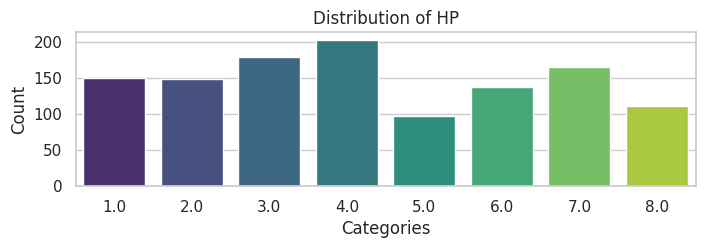

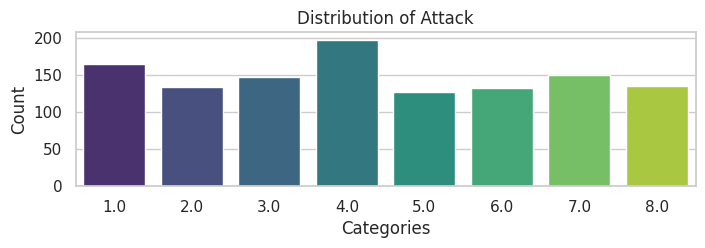

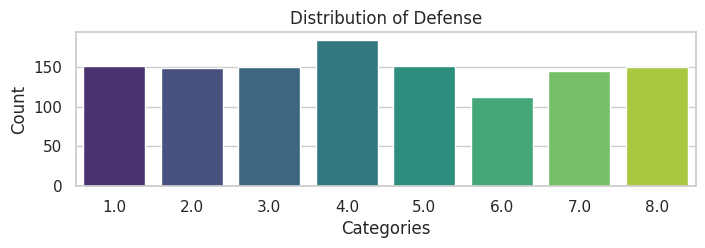

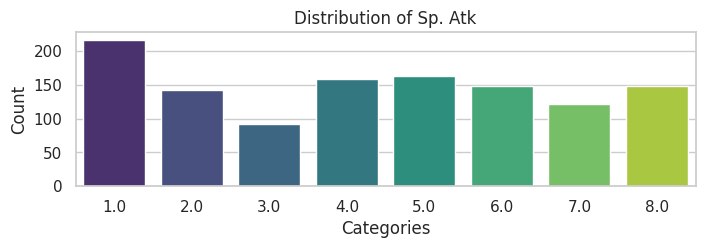

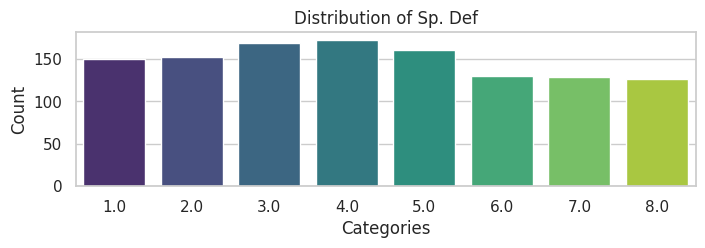

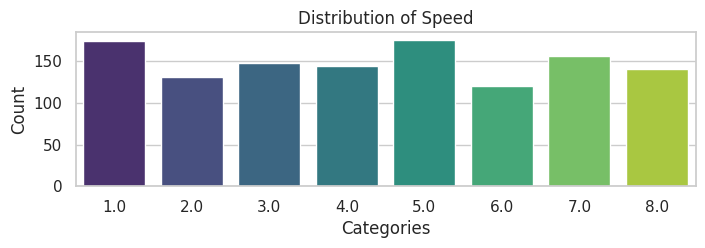

In [ ]:
# Assuming 'categorical_feature' is the column with categorical values
sns.set(style="whitegrid")  # Optional: Set the style of the plot
for i in Xc.columns:

  # Count the occurrences of each category
  category_counts = Xc[i].value_counts()

  # Plot the bar chart
  plt.figure(figsize=(8, 2))  # Optional: Adjust the figure size
  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
  plt.title(f"Distribution of {i}")
  plt.xlabel('Categories')
  plt.ylabel('Count')
  plt.show()

Todas las características están clasificadas de manera bastante equitativa

#### Entrenamiento

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(Xc, Y, test_size=0.2, random_state=42)

In [ ]:
# Definición y Entrenamiento del Modelo
mnb = MultinomialNB()
mnb.fit(X_train, Y_train);

#### Evaluaciones

Sobre el primer conjunto de test

In [ ]:
Y_pred = mnb.predict(X_test)

print("Precisión promedia:", metrics.precision_score(Y_test, Y_pred, average='macro', zero_division=0.0))
print("Exhaustividad promedia:",metrics.recall_score(Y_test, Y_pred, average='macro', zero_division=0.0))
print("Exactitud:", metrics.accuracy_score(Y_test, Y_pred))

Precisión promedia: 0.07548223302699006
Exhaustividad promedia: 0.09471118116587049
Exactitud: 0.1638655462184874


Sobre el segundo conjunto de test

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(Xc, Y, test_size=0.2, random_state=12345)

In [ ]:
Y_pred = mnb.predict(X_test)

print("Precisión promedia:", metrics.precision_score(Y_test, Y_pred, average='macro', zero_division=0.0))
print("Exhaustividad promedia:",metrics.recall_score(Y_test, Y_pred, average='macro', zero_division=0.0))
print("Exactitud:", metrics.accuracy_score(Y_test, Y_pred))

Precisión promedia: 0.09820762026644379
Exhaustividad promedia: 0.13786799620132953
Exactitud: 0.21008403361344538


### 6) K Vecinos Cercanos

In [ ]:
X = dataframe_std.drop(['Tipo','Type','Name', 'Nombre'], axis=1)
Y = dataframe_std['Type']

In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

#### Optimización de hiperparámetros

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=0)

params = {
    'n_neighbors':  range(1, 15, 2),
    'p': [1,2],
    'weights': ['uniform', 'distance']
}

clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, n_jobs=-1)
clf.fit(xTrain, yTrain)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", clf.best_params_)

mejor_modelo = grid_search.best_estimator_;

Mejores hiperparámetros: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


#### Evaluaciones

In [ ]:
yPred = mejor_modelo.predict(xTest)

In [ ]:
print("Precisión promedia:", metrics.precision_score(yTest, yPred, average='macro', zero_division=0.0))
print("Exhaustividad promedia:",metrics.recall_score(yTest, yPred, average='macro', zero_division=0.0))
print("Exactitud:", metrics.accuracy_score(yTest, yPred))

Precisión promedia: 0.1596599169073388
Exhaustividad promedia: 0.15466718600776572
Exactitud: 0.22268907563025211


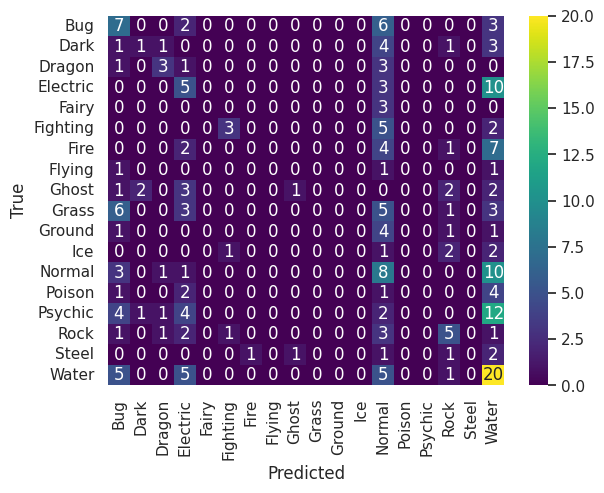

In [ ]:
cm = metrics.confusion_matrix(yTest, yPred)

# Plot confusion matrix
class_labels = label_encoder.inverse_transform(range(0,18))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Conclusiones

En el caso de las regresiones intentando predecir el profit de las compañías obtuvimos resultados increíblemente buenos, con errores muy pequeños. Pero sin haber probado con otros tipos de modelos no podemos concluir si se debe al método o lo describibles que es el dataset con regresiones.

Pero al contrario, en el caso de las clasificaciones de los pokemones, obtuvimos medidas bastante malas al evaluar los modelos. El mejor que nos dio fue el de  K Vecinos Cercanos, seguido por el de Bayes Ingenuo, y por último el de Árboles de Decisión.

Aún así obtuvimos resultados relativamente malos en todos, pudiendo ver incluso en la matriz de confusión del mejor modelo que al tratar con el conjunto de prueba, nunca predijo casi la mitad de las categorías.

Esto probablemente se deba al desbalanceo del dataset, que contiene muchos pokemones de ciertas categorías y muy pocos de otras. Esto podría ser resuelto con algún método de balanceo, pero quizás no sería suficiente en el caso de que el tipo de pokemon no dependa de las demás características que tenemos.